# Neural network

### Try to use our own preprocessing

In [32]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import sqlite3
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer
from time import time
from sklearn.decomposition import PCA
import warnings
from pathlib import Path

from utils.data_processing import create_feables
from utils.data_processing import confusion_matrix

warnings.simplefilter("ignore")

# You should run the ../../data_preprocessing.ipynb notebook to generate the data before running this
data = pd.read_csv("../../datasets/data.csv")
# data = data.tail(1000)

def normalize_bk_coefs(row, coef_name):
    keys = ['H', 'A', 'D']
    total = 0
    for key in keys:
        total += row[coef_name+key]
    
    for key in keys:
        row[coef_name+key] = row[coef_name+key] / total
    
    return row

# Normalize coefs
bk = ["B365", "BW", "IW", "LB", "WH", "VC"]
for coef_name in bk:
    data = data.apply(lambda row: normalize_bk_coefs(row, coef_name), axis=1)


labels = data.loc[:,'label']
features = data.drop('label', axis = 1)

print('Done')

Done


### Train test split with the test set being the results of the last 3 months. 

In [33]:
data = data.sort_values(['season', 'month'], ascending=(True, True))
test = data[(data['season'] == 2015) & (data['month'] > 8)]

y_test = test.loc[:, 'label']
X_test = test.drop('label', axis=1)

train = data[~data.isin(test)].dropna(how = 'all')
y_train = data.loc[:, 'label']
X_train = data.drop('label', axis=1)

In [34]:
from sklearn.model_selection import train_test_split
#Splitting the data into train, test
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.25, random_state = 42, shuffle = True, stratify = labels)

# Show some rows of the data
X_train.head()

,Unnamed: 0,season,month,stage,home_defencePressure,home_defenceAggression,home_defenceTeamWidth,away_defencePressure,away_defenceAggression,away_defenceTeamWidth,...,IWA,LBH,LBD,LBA,WHH,WHD,WHA,VCH,VCD,VCA
2321,2363.0,2009.0,8.0,2.0,30.0,30.0,30.0,30.0,30.0,30.0,...,0.265060,0.294479,0.398773,0.306748,0.320685,0.403917,0.275398,0.324130,0.390156,0.285714
14423,15306.0,2009.0,8.0,4.0,40.0,50.0,40.0,30.0,40.0,50.0,...,0.404494,0.235294,0.352941,0.411765,0.242938,0.361582,0.395480,0.241379,0.367816,0.390805
7731,8229.0,2012.0,11.0,14.0,65.0,50.0,60.0,45.0,55.0,45.0,...,0.504673,0.141825,0.361337,0.496838,0.141825,0.361337,0.496838,0.153153,0.360360,0.486486
16078,17082.0,2013.0,4.0,33.0,60.0,70.0,70.0,60.0,70.0,70.0,...,0.235294,0.402235,0.368715,0.229050,0.417582,0.357143,0.225275,0.414894,0.372340,0.212766
505,537.0,2010.0,9.0,7.0,70.0,50.0,70.0,60.0,60.0,65.0,...,0.566802,0.093546,0.326323,0.580131,0.085487,0.318091,0.596421,0.079755,0.306748,0.613497


In [35]:
print("Number of wins in test set:", np.sum(y_test == 2))
print("Number of draws in test set:", np.sum(y_test == 1))
print("Number of defeats in test set:", np.sum(y_test == 0))

Number of wins in test set: 2237
Number of draws in test set: 1230
Number of defeats in test set: 1405


In [36]:
# Match outcome
y_train.head()

# Number of possible outcomes
# 2 = win
# 1 = draw
# 0 = lose
print('Number of possible outcomes', np.unique(y_train.values).shape[0])
labels = np.unique(y_train.values)
print("Labels:", labels)


Number of possible outcomes 3
Labels: [0. 1. 2.]


In [37]:
# Get number of columns by getting the number of columns in the X_train
columns = X_train.shape[1]
print('Number of columns:', columns)

Number of columns: 31


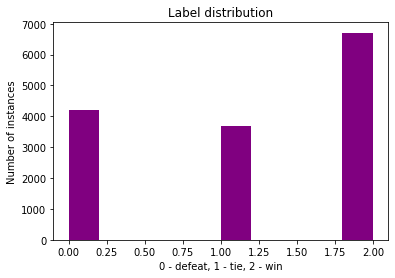

In [38]:
import matplotlib.pyplot as plt

# Plot the distribution of labels in the train data
def plot_labels_histogram(data):
    plt.hist(data, facecolor='purple', align='mid')
    plt.ylabel('Number of instances')
    plt.xlabel('0 - defeat, 1 - tie, 2 - win')
    plt.title("Label distribution")
    
plot_labels_histogram(y_train)

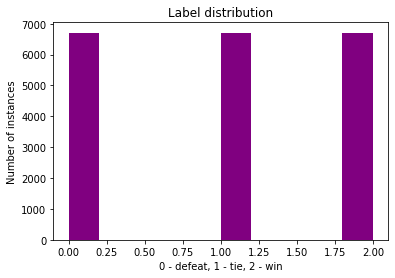

In [39]:
from imblearn.over_sampling import RandomOverSampler

# Since the train data is uneven and the dataset is not "huge" we need to upsamle/oversample
sampler = RandomOverSampler()
X_train_sampled, y_train_sampled = sampler.fit_sample(X_train, y_train)

# Plot the oversampled train set
plot_labels_histogram(y_train_sampled)

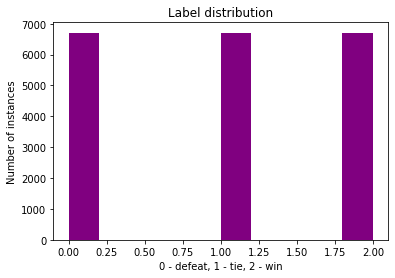

In [40]:
from sklearn.utils import shuffle

# Assign train values with the new sampled data
X_train, y_train = shuffle(X_train_sampled, y_train_sampled, random_state=42)

plot_labels_histogram(y_train)

In [41]:
from keras.models import Model, Sequential
from keras.layers import Input, Activation, Flatten, Dense, Dropout
from keras.optimizers import SGD, Adam
from keras import regularizers

def create_model(learning_rate=1e-5, dropout_rate=0.1):
    model = Sequential() 
    model.add(Dense(64, input_dim=columns, activation='tanh', kernel_regularizer='l2'))
    #model.add(Dropout(dropout_rate))
    #model.add(Dense(16, activation='relu', kernel_regularizer='l2'))
    model.add(Dropout(dropout_rate))
    #model.add(Dense(16, activation='relu', kernel_regularizer='l2'))
    #model.add(Dense(8, inputactivation='tanh', kernel_regularizer='l2'))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=learning_rate), metrics=['accuracy'])
    return model

In [42]:
from keras.utils.np_utils import to_categorical

# Convert a class vector (integers) to binary class matrix.
print("Unique labels in the train set: ", np.unique(y_train))
# One hot encoding
y_train_categorical = to_categorical(y_train, num_classes=len(labels))
print("Unique labels in the train set after encoding: ", np.unique(y_train_categorical, axis=0))

print("------------------------------------------------------------------------------ \n")


Unique labels in the train set:  [0. 1. 2.]
Unique labels in the train set after encoding:  [[0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]]
------------------------------------------------------------------------------ 



In [30]:
learning_rates = [1e-3, 5e-3, 1e-4, 5e-4, 1e-5, 1e-6]
dropout_rates = [0.05, 0.1, 0.2]

best_lr = None
best_dr = None

best_val_acc = 0
best_model = None
for lr in learning_rates:
    for dr in dropout_rates:
        print('Learning rate: {0}, Dropout rate: {1}'.format(lr, dr))
        model = create_model(lr, dr)
        history = model.fit(
            X_train,
            y_train_categorical,
            epochs=100,
            validation_split=0.1,
            verbose=0)
        val_acc = max(history.history['val_accuracy'])
        acc = max(history.history['accuracy'])
        print('Accuracy: {0}, Validation accuracy: {1}'.format(acc, val_acc))
        predictions = np.argmax(model.predict(X_test), axis=1)
        #print(np.unique(predictions))
        # Calculate accuracy
        accuracy = (predictions == y_test).mean()
        print("Test set accuracy:", accuracy)
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_lr = lr
            best_dr = dr
            best_model = model
            
            

print('Done')
        
        

Learning rate: 0.001, Dropout rate: 0.05
Accuracy: 0.34150245785713196, Validation accuracy: 0.34773969650268555
Test set accuracy: 0.257183908045977
Learning rate: 0.001, Dropout rate: 0.1
Accuracy: 0.3442623019218445, Validation accuracy: 0.34773969650268555
Test set accuracy: 0.2883825944170772
Learning rate: 0.001, Dropout rate: 0.2
Accuracy: 0.34420710802078247, Validation accuracy: 0.34972676634788513
Test set accuracy: 0.2883825944170772
Learning rate: 0.005, Dropout rate: 0.05
Accuracy: 0.34608379006385803, Validation accuracy: 0.34873324632644653
Test set accuracy: 0.458128078817734
Learning rate: 0.005, Dropout rate: 0.1
Accuracy: 0.34348952770233154, Validation accuracy: 0.34823647141456604
Test set accuracy: 0.4591543513957307
Learning rate: 0.005, Dropout rate: 0.2
Accuracy: 0.34514543414115906, Validation accuracy: 0.34773969650268555
Test set accuracy: 0.2883825944170772
Learning rate: 0.0001, Dropout rate: 0.05
Accuracy: 0.3496715724468231, Validation accuracy: 0.357675

In [33]:
best_lr

1e-05

In [34]:
best_dr

0.2

In [43]:
model = create_model(1e-05, 0.2)
history = model.fit(
            X_train,
            y_train_categorical,
            epochs=100,
            validation_split=0.1,
            verbose=1)
val_acc = max(history.history['val_accuracy'])
acc = max(history.history['accuracy'])
print('Accuracy: {0}, Validation accuracy: {1}'.format(acc, val_acc))

Train on 18117 samples, validate on 2013 samples
Epoch 1/100
18117/18117 [==============================] - 1s 33us/step - loss: 2.2733 - accuracy: 0.3322 - val_loss: 2.0370 - val_accuracy: 0.3378
Epoch 2/100
18117/18117 [==============================] - 0s 26us/step - loss: 2.0100 - accuracy: 0.3342 - val_loss: 1.7934 - val_accuracy: 0.3378
Epoch 3/100
18117/18117 [==============================] - 0s 26us/step - loss: 1.8179 - accuracy: 0.3300 - val_loss: 1.6353 - val_accuracy: 0.3348
Epoch 4/100
18117/18117 [==============================] - 0s 26us/step - loss: 1.6978 - accuracy: 0.3292 - val_loss: 1.5346 - val_accuracy: 0.3343
Epoch 5/100
18117/18117 [==============================] - 0s 26us/step - loss: 1.6171 - accuracy: 0.3301 - val_loss: 1.4735 - val_accuracy: 0.3348
Epoch 6/100
18117/18117 [==============================] - 0s 27us/step - loss: 1.5692 - accuracy: 0.3323 - val_loss: 1.4346 - val_accuracy: 0.3299
Epoch 7/100
18117/18117 [==============================] - 0s 2

Epoch 56/100
18117/18117 [==============================] - 1s 31us/step - loss: 1.1889 - accuracy: 0.3548 - val_loss: 1.1276 - val_accuracy: 0.3895
Epoch 57/100
18117/18117 [==============================] - 0s 27us/step - loss: 1.1903 - accuracy: 0.3514 - val_loss: 1.1292 - val_accuracy: 0.3646
Epoch 58/100
18117/18117 [==============================] - 0s 27us/step - loss: 1.1879 - accuracy: 0.3560 - val_loss: 1.1243 - val_accuracy: 0.4049
Epoch 59/100
18117/18117 [==============================] - 0s 27us/step - loss: 1.1812 - accuracy: 0.3609 - val_loss: 1.1225 - val_accuracy: 0.3875
Epoch 60/100
18117/18117 [==============================] - 0s 26us/step - loss: 1.1796 - accuracy: 0.3636 - val_loss: 1.1281 - val_accuracy: 0.3920
Epoch 61/100
18117/18117 [==============================] - 0s 26us/step - loss: 1.1787 - accuracy: 0.3621 - val_loss: 1.1177 - val_accuracy: 0.4054
Epoch 62/100
18117/18117 [==============================] - 1s 29us/step - loss: 1.1727 - accuracy: 0.3671

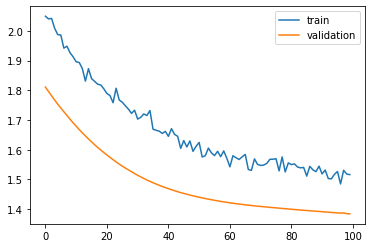

In [16]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

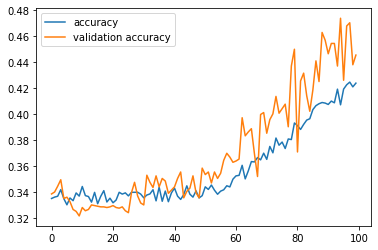

In [37]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.show()

In [38]:
# Take the most probable prediction
# print(model.predict(X_test))
predictions = np.argmax(model.predict(X_test), axis=1)
print(np.unique(predictions))
# Calculate accuracy
accuracy = (predictions == y_test).mean()
print("Test set accuracy:", accuracy)

[0 1 2]
Test set accuracy: 0.4205665024630542


# Let us plot the confusion matrix

3164
[0 1 2]
Neural network confusion matrix: 
                    Home wins (pred)  Draw (pred)  Home loses (pred)
Home wins (true)                798         1292                147
Draw (true)                     174          913                143
Home loses (true)               108          959                338

 True labels distribution: 



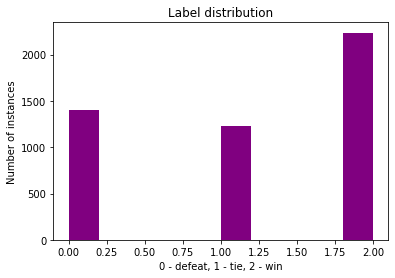

In [39]:
# from utils.data_processing import build_confusion_matrix

# TODO: Remove this and use the commented import instead
def build_confusion_matrix(y_true, y_pred):
    return pd.DataFrame(confusion_matrix(y_true, y_pred, labels=[2, 1, 0]),
                        index=['Home wins (true)', 'Draw (true)', 'Home loses (true)'],
                        columns=['Home wins (pred)', 'Draw (pred)', 'Home loses (pred)'])

print(np.sum((predictions == 1)))
print(np.unique(predictions))
print("Neural network confusion matrix: \n", build_confusion_matrix(y_test, predictions))


print('\n True labels distribution: \n')
plot_labels_histogram(y_test)

# Comparing Neural network to Random forest

In [40]:
#Splitting the data into Train, Calibrate, and Test data sets
#X_train_calibrate, X_test, y_train_calibrate, y_test = train_test_split(features, labels, test_size = 0.25, random_state = 0, stratify = labels)
X_train_calibrate = X_train
y_train_calibrate = y_train
X_train, X_calibrate, y_train, y_calibrate = train_test_split(X_train_calibrate, y_train_calibrate, test_size = 0.25, random_state = 0, stratify = y_train_calibrate)


In [45]:
from utils.data_processing import train_calibrate_predict

# Creating cross validation data splits
cv_sets = model_selection.StratifiedShuffleSplit(n_splits = 5, test_size = 0.20, random_state = 5)
cv_sets.get_n_splits(X_train, y_train)

# Init Random Forest
RF_clf = RandomForestClassifier(n_estimators = 200, random_state = 1, class_weight = 'balanced')

#Specficying scorer and parameters for grid search
feature_len = X_train.shape[1]
scorer = make_scorer(accuracy_score)
parameters_RF = {'clf__max_features': ['auto', 'log2'], 'dm_reduce__n_components': np.arange(5, feature_len, int(np.around(feature_len/5)))}

#Initializing dimensionality reductions
pca = PCA()
RF_clf.fit(X_train, y_train)

print("Random forest accuracy for train set.".format(RF_clf.__class__.__name__, accuracy_score(y_train, RF_clf.predict(X_train))))
print("Random forest accuracy for test set".format(RF_clf.__class__.__name__, accuracy_score(y_test, RF_clf.predict(X_test))))

#Grid search, calibrate, and test the classifier
calibrated_RF_clf, dm_reduce, train_score, test_score = train_calibrate_predict(clf = RF_clf, dm_reduction = pca, X_train = X_train, y_train = y_train,
                                                                  X_calibrate = X_calibrate, y_calibrate = y_calibrate,
                                                                  X_test = X_test, y_test = y_test, cv_sets = cv_sets,
                                                                  params = parameters_RF, scorer = scorer, jobs = 1, use_grid_search = True)

Random forest accuracy for train set.
Random forest accuracy for test set
Training a RandomForestClassifier with PCA...
Trained RandomForestClassifier in 30.1 minutes
Calibrating probabilities of classifier...
Calibrated CalibratedClassifierCV in 0.0 minutes
Made predictions in 2.4444 seconds
Score of CalibratedClassifierCV for training set: 1.0000.
Made predictions in 0.9006 seconds
Score of CalibratedClassifierCV for test set: 0.5807.
Made predictions in 2.3736 seconds
Made predictions in 0.8684 seconds


In [48]:
rf_predictions = RF_clf.predict(X_test)

# Calculate accuracy
accuracy = (rf_predictions == y_test).mean()
print("Random forest test set accuracy:", accuracy)

Random forest test set accuracy: 0.5769704433497537


In [49]:
print("Random forest confusion matrix: \n", build_confusion_matrix(y_test, rf_predictions))

Random forest confusion matrix: 
                    Home wins (pred)  Draw (pred)  Home loses (pred)
Home wins (true)               1543          350                344
Draw (true)                     389          547                294
Home loses (true)               366          318                721


# Conclusion

Random Forest Classifier is more effective in predicting football games

In [44]:
model.save('neural_network.h5')